In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import reset_seed, display_compare

import os

# tf.config.experimental.get_visible_devices()

In [2]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)
print(x_train.shape)

(45000, 28, 28)


## VAEs
Let's implement a VAE by subclassing the Model class

In [9]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Lambda, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.nn import leaky_relu

def sampling_fn(inputs):
    mean, log_var = inputs
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(log_var / 2) + mean

def make_VEncoder(latent_dim):
    x = Input(shape=[28, 28])
    hidden = Flatten()(x)
    hidden = Dense(150, activation=leaky_relu)(hidden)
    hidden = Dense(100, activation=leaky_relu)(hidden)
    
    # Here the magic!
    mean = Dense(latent_dim)(hidden)
    log_var  = Dense(latent_dim)(hidden)
    # Sample from N(z|mean, var)
    codings = Lambda(sampling_fn, name="sampling_layer")([mean, log_var])
    
    encoder = Model(inputs=[x], outputs=[codings, mean, log_var])
    return encoder

def make_VDecoder(latent_dim):
    # As before!
    decoder = Sequential([
        Dense(100, activation=leaky_relu, input_shape=[latent_dim]),
        Dense(150, activation=leaky_relu),
        Dense(28 * 28, activation="sigmoid"),
        Reshape([28, 28])
    ])
    return decoder

def make_VAE(latent_dim=100, kl_factor=0.0015):
    # create the two models..
    encoder = make_VEncoder(latent_dim)
    decoder = make_VDecoder(latent_dim)
    
    # Stack them together...
    x = Input(shape=[28, 28])
    codings, mean, log_var = encoder(x)
    reconstruction = decoder(codings)
    VAE = Model(inputs=[x], outputs=[reconstruction])
    
    # Add the extra loss function
    kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=-1)
    VAE.add_loss(kl_factor * tf.reduce_mean(kl_loss))
    return VAE

In [10]:
reset_seed()
vae = make_VAE(2)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")
vae.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
352/352 [==============================] - 1s 4ms/step - loss: 0.4051 - val_loss: 0.3692
Epoch 2/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3634 - val_loss: 0.3598
Epoch 3/25
352/352 [==============================] - 1s 4ms/step - loss: 0.3568 - val_loss: 0.3559
Epoch 4/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3530 - val_loss: 0.3507
Epoch 5/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3502 - val_loss: 0.3485
Epoch 6/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3482 - val_loss: 0.3475
Epoch 7/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3465 - val_loss: 0.3464
Epoch 8/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3451 - val_loss: 0.3443
Epoch 9/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3439 - val_loss: 0.3433
Epoch 10/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3429 - val_loss: 0.3435

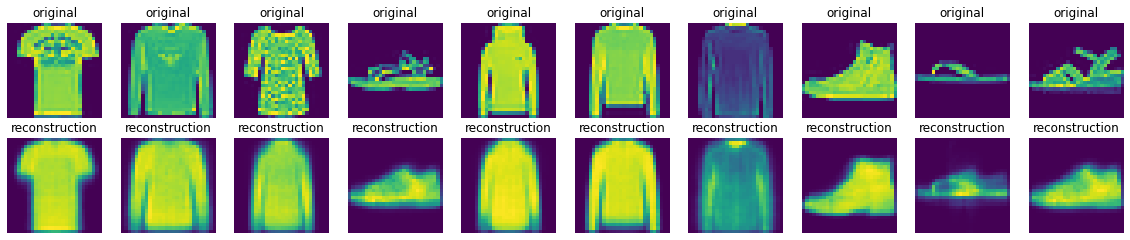

In [11]:
rec_vae = vae.predict(x_val)

display_compare(x_val, rec_vae, names=["original", "reconstruction"])

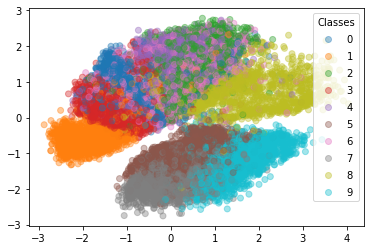

In [12]:
v_encoder = vae.layers[1]
codings, *_ = v_encoder(x_val)
codings.shape
scatter = plt.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.4)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")

In [13]:
def get_curve(n_points=50, x_scale=1.5, y_scale=4):
    t_ = np.linspace(0,2*np.pi,n_points)
    curve_x = x_scale * np.sin(t_)
    curve_y = y_scale * np.sin(t_) * np.cos(t_)
    curve = np.vstack([curve_x, curve_y]).transpose()
    return np.float32(curve)

curve     = get_curve()
decoder   = vae.layers[2]
curve_rec = decoder(curve)

Done in 43.11s


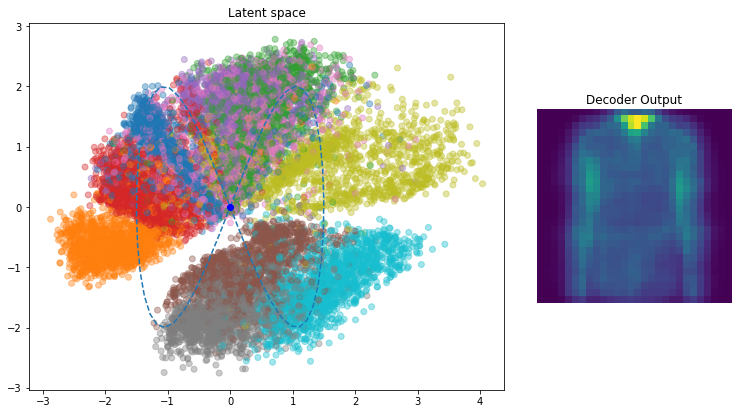

In [14]:
from time import time
from matplotlib.animation import FuncAnimation

start =time()
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.05, 0.05, .55, 0.85])
ax2 = fig.add_axes([.6, 0.25, 0.3, 0.45])
ax2.axis('off')
ax.set_title('Latent space')
title = ax2.set_title('Decoder Output')
ax.plot(*np.hsplit(curve,2), ls='--')

ax.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.4)
point, = ax.plot(*curve[0], 'bo')
img = ax2.imshow(curve_rec[0])

def update(i):
    point.set_data(*curve[i])
    img = ax2.imshow(curve_rec[i])
    return point, img

anim = FuncAnimation(fig, update, frames=np.arange(len(curve)), interval=200)
anim.save('VAE_f.gif', writer='imagemagick')
print("Done in %.2fs"%(time()-start))